In [ ]:
from google.colab import drive
! pip install -q kaggle

In [ ]:
import requests, re, time
import torch, torchvision
from torch import nn, optim
from torchvision import datasets, models, transforms

import os
import numpy as np



In [ ]:
import keras

import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics

from sklearn.utils import class_weight
from collections import Counter

import matplotlib.pyplot as plt

from os import listdir
from os.path import isfile, join
import glob

import pandas as pd
import urllib.request

The database is a food 5k database from kaggle
> https://www.kaggle.com/datasets/binhminhs10/food5k




In [ ]:
def extract_data():      
    if "Food-5K" in os.listdir() or "food-5k" in os.listdir() :
        print("Dataset already exists")
    else:
        print("Getting kaggle API token")
        !cp /content/drive/MyDrive/CPEN391_team_penguin/kaggle.json ~/.kaggle/kaggle.json
        print("Kaggle API token goten!")
        print("Downloading the data...")
        !kaggle datasets download -d binhminhs10/food5k -p /content/
        print("Dataset downloaded!")
        print("Extracting data..")
        !unzip food5k.zip
        print("Extraction done!")



In [ ]:
extract_data()
extract_data()

Streaming output truncated to the last 5000 lines.
  inflating: food-5k/Food-5K/evaluation/0_1.jpg  
  inflating: food-5k/Food-5K/evaluation/0_10.jpg  
  inflating: food-5k/Food-5K/evaluation/0_100.jpg  
  inflating: food-5k/Food-5K/evaluation/0_101.jpg  
  inflating: food-5k/Food-5K/evaluation/0_102.jpg  
  inflating: food-5k/Food-5K/evaluation/0_103.jpg  
  inflating: food-5k/Food-5K/evaluation/0_104.jpg  
  inflating: food-5k/Food-5K/evaluation/0_105.jpg  
  inflating: food-5k/Food-5K/evaluation/0_106.jpg  
  inflating: food-5k/Food-5K/evaluation/0_107.jpg  
  inflating: food-5k/Food-5K/evaluation/0_108.jpg  
  inflating: food-5k/Food-5K/evaluation/0_109.jpg  
  inflating: food-5k/Food-5K/evaluation/0_11.jpg  
  inflating: food-5k/Food-5K/evaluation/0_110.jpg  
  inflating: food-5k/Food-5K/evaluation/0_111.jpg  
  inflating: food-5k/Food-5K/evaluation/0_112.jpg  
  inflating: food-5k/Food-5K/evaluation/0_113.jpg  
  inflating: food-5k/Food-5K/evaluation/0_114.jpg  
  inflating: food

In [ ]:
directory = "Food_5K_proper"
def create_dataset_dir(directory = directory):    
    if directory in os.listdir():
        print("Dataset already exists")
    else:  
        os.mkdir(f"{directory}")  
        os.mkdir(f"{directory}/non_food")
        os.mkdir(f"{directory}/food")
        print("Dataset directory Created")
def create_dataset(directory = directory,root = "Food-5K"):
    from fnmatch import fnmatch
    pattern = "*.jpg"

    file_names = [os.path.join(path, name) for path, subdirs, files in os.walk(root) for name in files if fnmatch(name,pattern)]

    import shutil    
        
    for file_name in file_names:
        try:
            shutil.move(file_name, f"{directory}/")
        except:    
            pass

    file_names = [os.path.join(path, name) for path, subdirs, files in os.walk(directory) for name in files if fnmatch(name,pattern)]

    for file_name in file_names:        
        print(file_name[len(directory)+1:])
        if (file_name[len(directory)+1:])[0] == '0':
            try:
                shutil.move(file_name, f"{directory}/non_food")
            except:
                pass    
        else:  
            try:
                shutil.move(file_name, f"{directory}/food")  
            except:
                pass
    print("Dataset Created")

In [ ]:
create_dataset_dir()
create_dataset()

Dataset directory Created
0_432.jpg
1_1290.jpg
0_523.jpg
1_1130.jpg
1_6.jpg
1_975.jpg
1_1413.jpg
1_699.jpg
1_603.jpg
1_1065.jpg
0_1149.jpg
1_545.jpg
0_734.jpg
0_1304.jpg
0_535.jpg
1_990.jpg
0_508.jpg
0_1420.jpg
0_313.jpg
1_231.jpg
0_596.jpg
1_375.jpg
1_696.jpg
1_1344.jpg
1_513.jpg
0_691.jpg
0_117.jpg
0_225.jpg
0_965.jpg
1_1061.jpg
1_876.jpg
0_720.jpg
1_900.jpg
0_1411.jpg
0_876.jpg
1_573.jpg
1_1491.jpg
1_938.jpg
1_184.jpg
1_396.jpg
0_368.jpg
0_346.jpg
0_436.jpg
1_588.jpg
0_867.jpg
1_297.jpg
1_240.jpg
0_236.jpg
1_1239.jpg
1_647.jpg
0_1241.jpg
1_467.jpg
0_1023.jpg
0_1207.jpg
1_1369.jpg
0_1365.jpg
1_1390.jpg
1_1171.jpg
0_1395.jpg
0_211.jpg
1_16.jpg
0_880.jpg
0_602.jpg
1_130.jpg
1_464.jpg
0_392.jpg
1_1118.jpg
1_238.jpg
1_824.jpg
0_1051.jpg
1_366.jpg
1_908.jpg
1_654.jpg
0_1243.jpg
0_1349.jpg
0_170.jpg
0_316.jpg
1_799.jpg
0_539.jpg
1_56.jpg
1_1070.jpg
0_302.jpg
0_141.jpg
1_1233.jpg
1_648.jpg
1_462.jpg
0_1255.jpg
1_1087.jpg
1_1311.jpg
1_1297.jpg
0_7.jpg
0_710.jpg
0_283.jpg
0_440.jpg
1_976.jpg


In [ ]:
dataset_full_loc = directory
os.listdir(dataset_full_loc)

['food', 'non_food']

In [ ]:
# Visualize the data, showing one image per class from 80 classes
def visualize_classes():
    rows = 2
    cols = 2
    fig, ax = plt.subplots(rows+1, cols, figsize=(25,25))
    fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    data_dir = dataset_full_loc
    foods_sorted = sorted(os.listdir(data_dir))
    food_id = 0
    for i in range(rows):
        for j in range(cols):
            try:
                food_selected = foods_sorted[food_id] 
                food_id += 1
            except:
                break
            if food_selected == '.DS_Store':
                continue
            food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
            food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
            img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
           
            ax[i][j].imshow(img)
            ax[i][j].set_title(food_selected, pad = 10)
        
    plt.setp(ax, xticks=[],yticks=[])
    #plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/random_img_classes.svg', format='svg', dpi=1200)
    plt.tight_layout()

    # https://matplotlib.org/users/tight_layout_guide.html

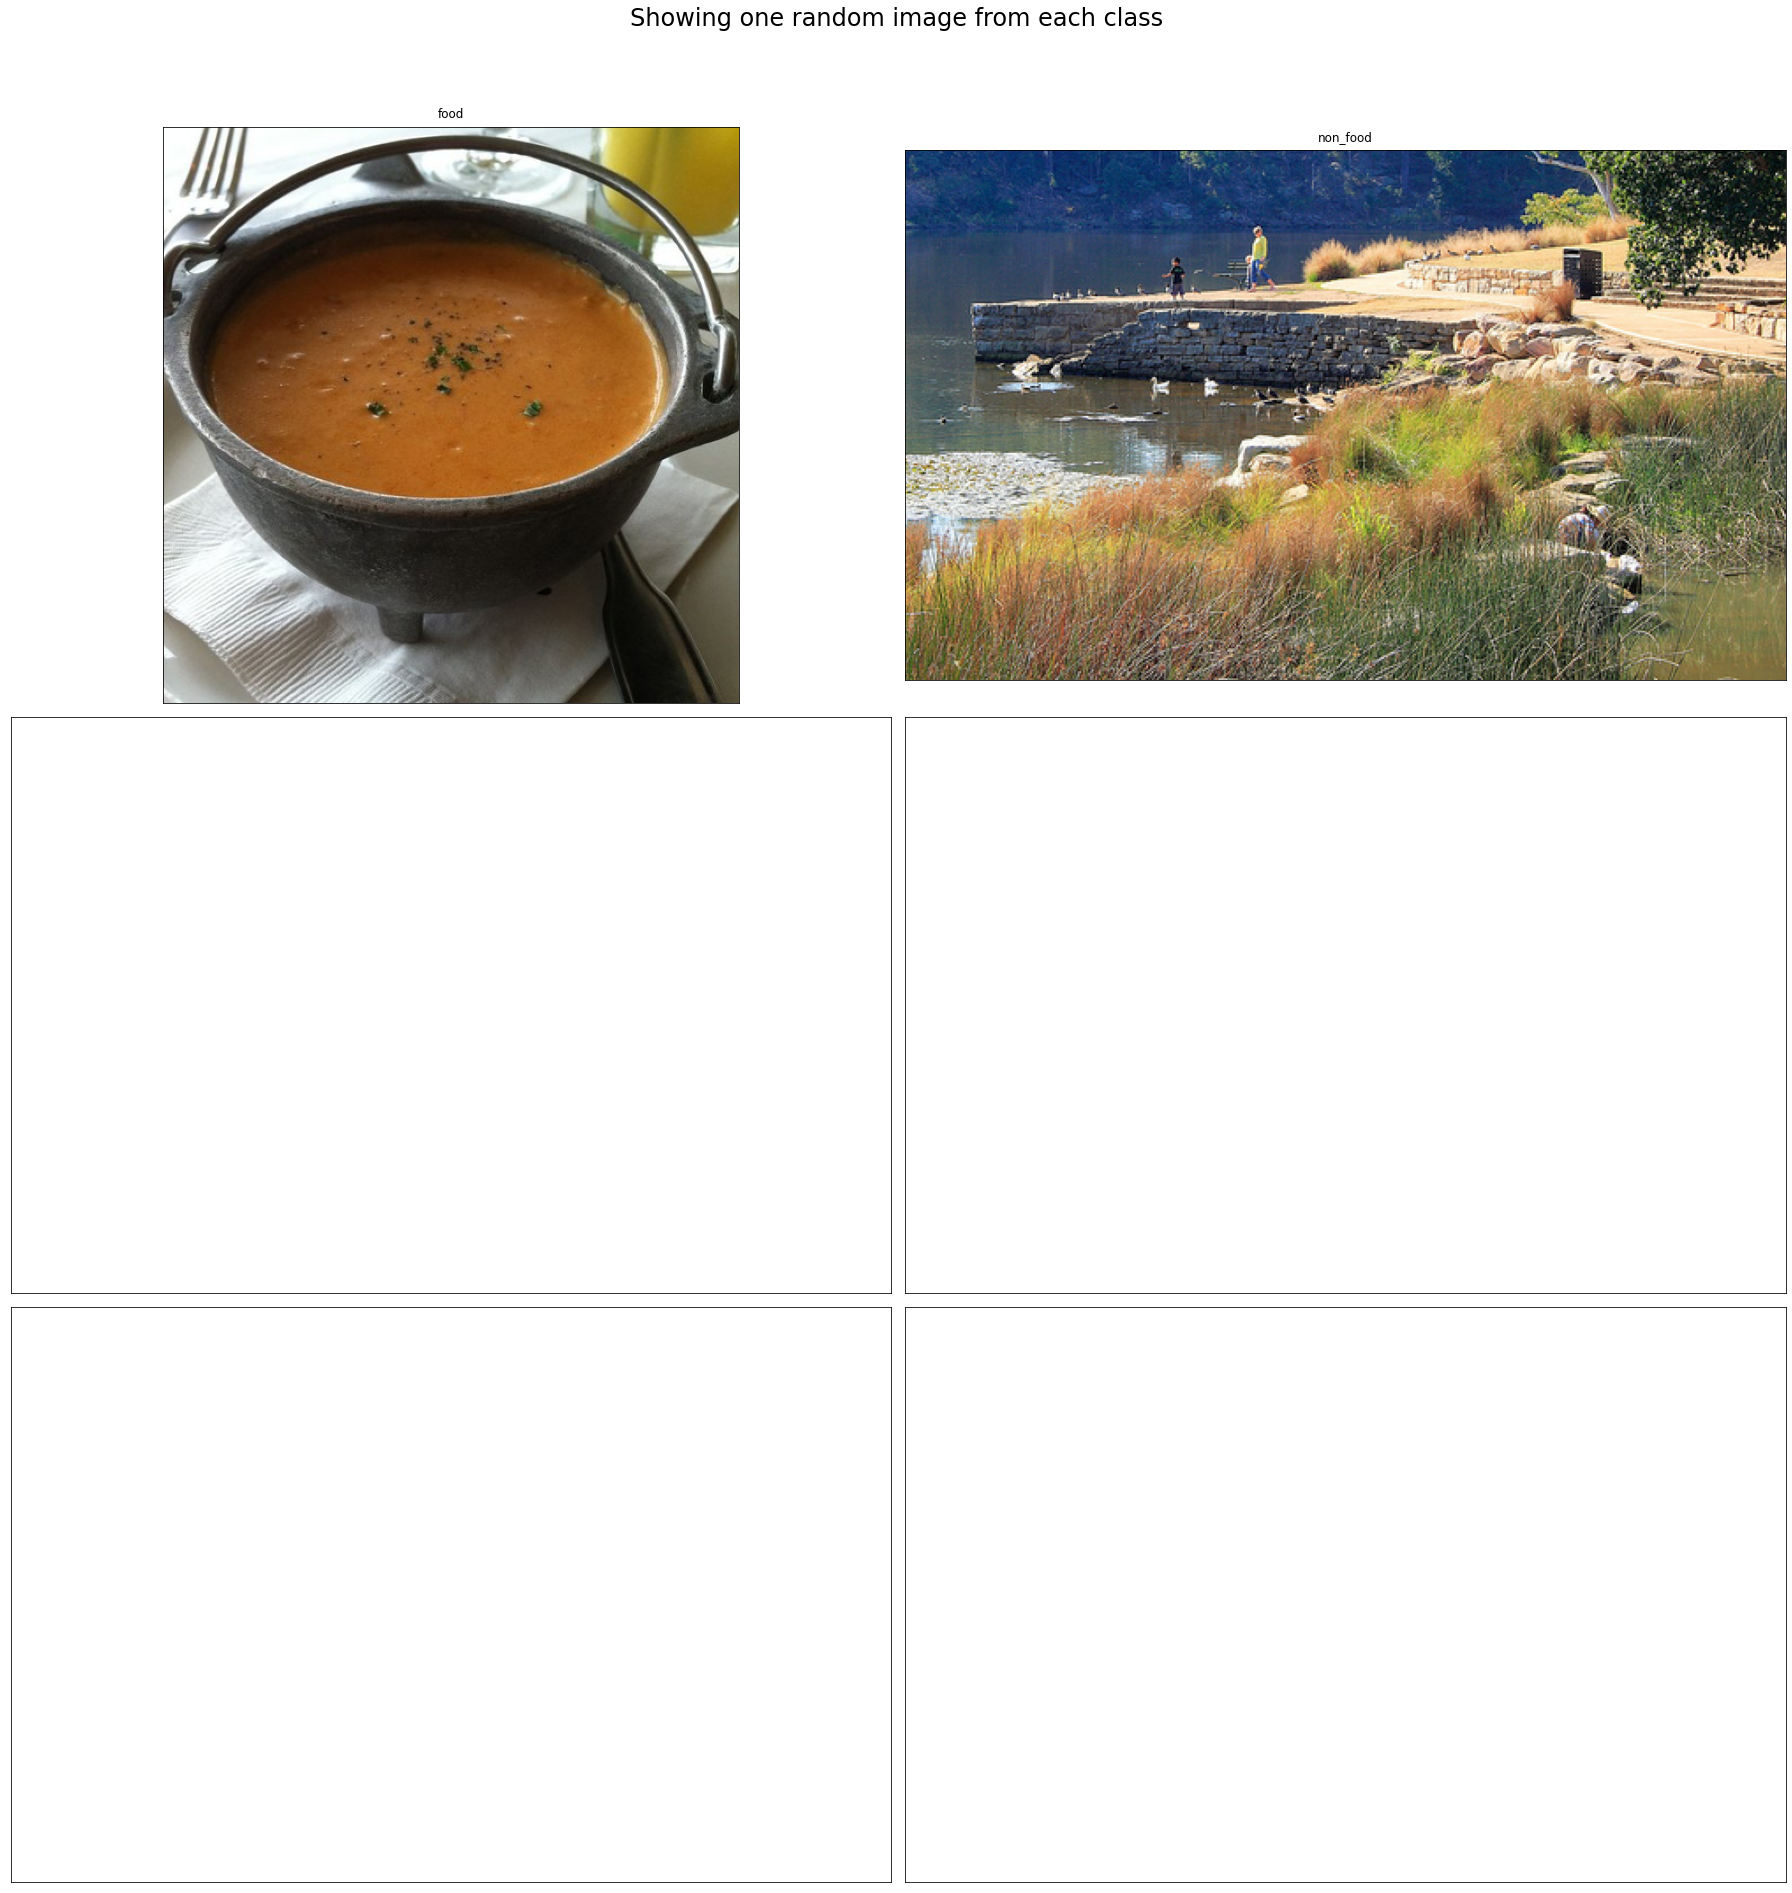

In [ ]:
visualize_classes()

I use keras ImageDataGenarator to split and augment my dataset

In [ ]:
# Preprocessing settings for training data
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range=20,
    height_shift_range=0.2,
    width_shift_range=0.2,
    shear_range=0.01,
    zoom_range=[0.9, 1.25],
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='reflect',
    validation_split = 0.2)



In [ ]:
# Apply data transfers and create generators for training and test data
train_generator = train_datagen.flow_from_directory(
        directory=dataset_full_loc,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset='training')

validation_generator = train_datagen.flow_from_directory(
        directory=dataset_full_loc,
        target_size=(256, 256),
        batch_size=32,
        class_mode='categorical',
        subset='validation')

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
labels
import json

# as requested in comment


with open('classes.json', 'w') as file:
     file.write(json.dumps(labels)) # use `json.loads` to do the reverse


I use pretrained InceptionV3 model which is one of the highest accuracy models in imagenet excluding Xception

In [ ]:
# Cell below is used to initiate a cnn network


# Specify the shape of inputs
input_shape = (256,256,3)
batch_size = 32
n_classes = len(os.listdir(dataset_full_loc))

# Set up model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=keras.layers.Input(shape=input_shape))
x = base_model.output
x = keras.layers.AveragePooling2D(pool_size=(6, 6))(x)
x = keras.layers.Dropout(.4)(x)
x = keras.layers.Flatten()(x)
predictions = keras.layers.Dense(n_classes,  kernel_initializer='glorot_uniform', kernel_regularizer=keras.regularizers.L2(.0005), activation='softmax', name='predictions')(x)
model = Model(inputs=base_model.input, outputs=predictions)
# Display model
#model.summary()

# Show if GPU is avialable
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Initaite mode, specify the optimizer, lossfunction and metrics
opt = tf.keras.optimizers.Adam()

model.compile(optimizer = opt,
            loss ='categorical_crossentropy',
            metrics=['accuracy'])

# Save weights if model improved
filepath = "best-weights-improvement.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Early stopping in case val_loss < min_delta for a specific number of runs 
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=20, verbose=1, mode='auto', baseline=None, restore_best_weights=False)

# Set callbacks 
callbacks_list = [checkpoint, early_stopping]

# same model as whole
model.save("Inception_transfer_10epocs.h5")


    


Num GPUs Available:  1


In [ ]:
# Fit data & train model
hist = model.fit(
            train_generator,
            steps_per_epoch = train_generator.samples // batch_size,
            callbacks = callbacks_list,
            epochs = 100,
            validation_data = validation_generator,
            validation_steps = validation_generator.samples // batch_size)

Epoch 1/100
75/75 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8700
Epoch 1: val_accuracy improved from -inf to 0.56424, saving model to best-weights-improvement.hdf5
75/75 [==============================] - 76s 933ms/step - loss: 0.3900 - accuracy: 0.8700 - val_loss: 1.5963 - val_accuracy: 0.5642
Epoch 2/100
75/75 [==============================] - ETA: 0s - loss: 0.1940 - accuracy: 0.9346
Epoch 2: val_accuracy improved from 0.56424 to 0.87847, saving model to best-weights-improvement.hdf5
75/75 [==============================] - 67s 893ms/step - loss: 0.1940 - accuracy: 0.9346 - val_loss: 1.7972 - val_accuracy: 0.8785
Epoch 3/100
75/75 [==============================] - ETA: 0s - loss: 0.1753 - accuracy: 0.9425
Epoch 3: val_accuracy did not improve from 0.87847
75/75 [==============================] - 66s 875ms/step - loss: 0.1753 - accuracy: 0.9425 - val_loss: 2.0269 - val_accuracy: 0.6771
Epoch 4/100
75/75 [==============================] - ETA: 0s - loss

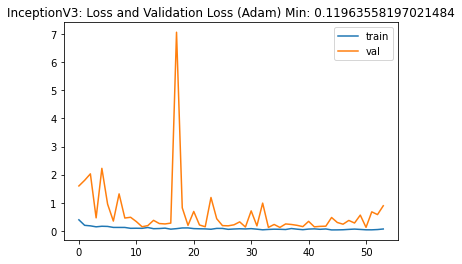

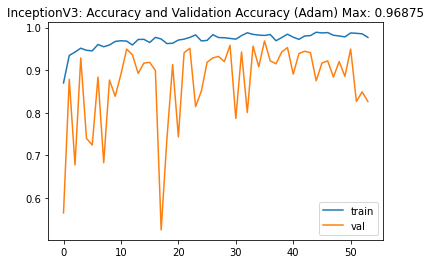

In [ ]:


plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='val')
plt.title(f"InceptionV3: Loss and Validation Loss (Adam) Min: {min(hist.history['val_loss'])}")
plt.legend();
plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/binary_class_loss.png')
plt.show()

plt.plot(hist.history['accuracy'], label='train')
plt.plot(hist.history['val_accuracy'], label='val')
plt.title(f"InceptionV3: Accuracy and Validation Accuracy (Adam) Max: {max(hist.history['val_accuracy'])}")
plt.legend();
plt.savefig('/content/drive/MyDrive/CPEN391_team_penguin/binary_class_accuracy.png')
plt.show()



In [ ]:
max_acc = max(hist.history['val_accuracy'])
max_acc

0.96875

In [ ]:
model.save(f'/content/drive/MyDrive/CPEN391_team_penguin/Model/InceptionV3/binary_class_save{max_acc}acc')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/CPEN391_team_penguin/Model/InceptionV3/binary_class_save0.96875acc/assets


The below checks the accuracy of the model in detecting indian food. It sucessfully detects all the pictures in the given dataset

In [ ]:
# Predict & submit 
# Uncomment to load previous model
# model = tf.keras.models.load_model('/kaggle/input/ml-model-v2/whole_model_v4.h5')

test_directory = '/content/drive/MyDrive/food indian_food test'

# Test data generator -> Rescale image size
test_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255)

# apply test_datagen to input files
test_generator = test_datagen.flow_from_directory(
        directory=test_directory,
        target_size=(256, 256),
        shuffle = False,
        class_mode=None,
        batch_size=1)

# Get the filenames & remove directory specification in front of filename
filenames = [filename for filename in test_generator.filenames]

# Not predicting in batches but each inidividual item, therefore we need to know the amount of predictions
nb_samples = len(filenames)



Found 58 images belonging to 2 classes.


In [ ]:

# Make predictions, returns probabilities for each class
print(f'Making predictions....')
model_loc = "/content/drive/MyDrive/CPEN391_team_penguin/Model/InceptionV3/binary_class_save0.96875acc"
model = keras.models.load_model(model_loc)
model_predictions = model.predict(test_generator,steps = nb_samples, verbose=1)

In [ ]:
# Assign prediction to class with highest probability
y_pred_labels = np.argmax(model_predictions, axis = 1)

# Map predictions to the correct labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

predictions = [labels[k] for k in y_pred_labels]

#print(predictions)

# Submit file
submission = pd.DataFrame({'img_name':filenames,'label':predictions})
submission.to_csv('submission.csv', index=False)
print("Done!")

{0: 'food', 1: 'non_food'}
Done!


In [ ]:
# Assign prediction to class with highest probability
y_pred_labels = np.argmax(model_predictions, axis = 1)

# Map predictions to the correct labels
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)
predictions = [labels[k] for k in y_pred_labels]

#print(predictions)

# Submit file
submission = pd.DataFrame({'img_name':filenames,'label':predictions})
submission.to_csv('/content/drive/MyDrive/CPEN391_team_penguin/binary_submission.csv', index=False)
print("Done!")

{0: 'food', 1: 'non_food'}
Done!
